In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

<img src="https://media.discordapp.net/attachments/1004748557477224498/1087138296477532243/MAD_Web_illustration_for_data_taxi_299ed35e-f711-4f19-8747-d4604bfc8c9b.png?width=1206&height=676" width="600" align="center"/>

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [214]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [215]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
EDA - это первый шаг в любом проекте. Посмотрите на данные, посчитайте основные статистики, постройте графики. Попробуйте ответить на вопросы:

Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [216]:
# Посмотрим сколько значений отсутствует в каждой колонке
df.isnull().sum()
 

Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [217]:
# Определим вещественные колонки
numeric_columns = df.loc[:,df.dtypes!=object].columns
df.loc[:,df.dtypes!=object].head(2)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
Trip_ID,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.905,0,40.0,46,60,2
T0005689461,29.47,10.0,2.78245,3.450,0,38.0,56,78,2


In [218]:
# Определим категориальные колонки
categorical_columns = df.loc[:,df.dtypes==object].columns
df.loc[:,df.dtypes==object].head(2)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
Trip_ID,,,,
T0005689460,B,A,A,Female
T0005689461,B,B,A,Male


In [219]:
# Заменяем пропуски на среднее значение
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

In [220]:
# Заполним пропуски в категориальных колонках на самое частое значение
for col in categorical_columns:
    most_frequent = df[col].mode()[0]
    df[col] = df[col].fillna(most_frequent)

In [221]:
# Посмотрим сколько значений отсутствует в каждой колонке
df.isnull().sum()

Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var1                           0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64

In [222]:
# Строим матрицу корреляций
correlation_matrix = df[numeric_columns].corr()


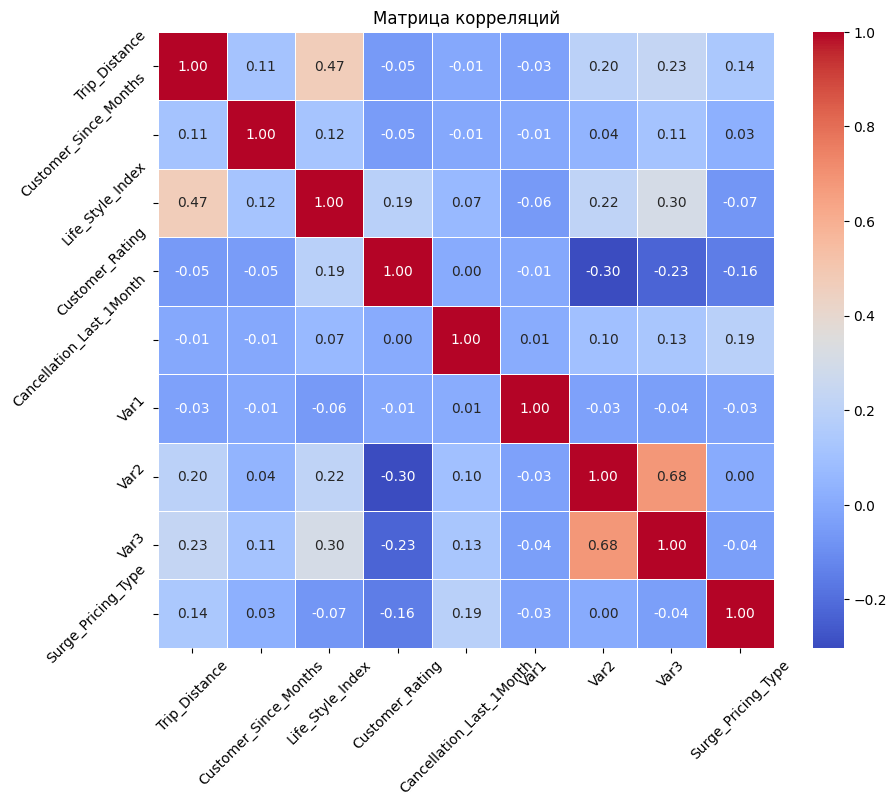

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение матрицы корреляций
correlation_matrix = df[numeric_columns].corr()

# Настройка размера графика
plt.figure(figsize=(10, 8))

# Визуализация матрицы корреляций с помощью heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, square=True)

# Настройка заголовка и осей
plt.title("Матрица корреляций")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Отображение графика
plt.show()


В этом коде мы используем функцию heatmap из библиотеки Seaborn для визуализации матрицы корреляций. Мы задаем параметры, такие как annot=True для отображения значений корреляции в каждой ячейке, `cmap="coolwarm"` для выбора цветовой схемы и `fmt=".2f"` для форматирования числовых значений. Также мы настраиваем размер графика, заголовок и вращение меток осей для лучшей читаемости.

In [224]:
# Выводим топ-5 пар самых сильно скоррелированных признаков

sorted_correlations = correlation_matrix.unstack().sort_values(ascending=False, key=abs)
top_5_correlations = sorted_correlations[sorted_correlations < 1].head(10)
print(top_5_correlations)

Var2              Var3                0.683437
Var3              Var2                0.683437
Trip_Distance     Life_Style_Index    0.468367
Life_Style_Index  Trip_Distance       0.468367
Var3              Life_Style_Index    0.303296
Life_Style_Index  Var3                0.303296
Var2              Customer_Rating    -0.302968
Customer_Rating   Var2               -0.302968
Var3              Trip_Distance       0.231706
Trip_Distance     Var3                0.231706
dtype: float64


In [225]:
# Распечатаем head категориальных признаков
df[categorical_columns].head()

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
Trip_ID,,,,
T0005689460,B,A,A,Female
T0005689461,B,B,A,Male
T0005689464,B,B,E,Male
T0005689465,C,B,A,Male
T0005689467,C,B,A,Male


In [226]:
# One-Hot-Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df_encoded.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.427690,3.90500,0,40.000000,46,60,2,1,...,0,0,0,0,0,0,0,0,0,0
T0005689461,29.47,10.0,2.782450,3.45000,0,38.000000,56,78,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689464,41.58,10.0,2.802064,3.50125,2,64.202698,56,77,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689465,61.56,10.0,2.802064,3.45375,0,64.202698,52,74,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005689467,54.95,10.0,3.034530,3.40250,4,51.000000,49,102,2,0,...,0,0,0,0,0,0,0,0,0,1


Теперь у вас есть подготовленный набор данных с заполненными пропусками и закодированными категориальными признаками, который можно использовать для дальнейшего анализа или обучения модели.

### Training

In [227]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = df_encoded.drop('Surge_Pricing_Type', axis=1)

# Surge_Pricing_Type - целевая переменная
y = df_encoded['Surge_Pricing_Type']

X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [228]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Создаем пайплайн
pipe = Pipeline([('scaler', StandardScaler()), 
                        ('one_vs_all', OneVsRestClassifier(LogisticRegression()))])

In [229]:
# Обучаем модель
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [230]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.722     0.542     0.619      5372
           2      0.636     0.835     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Этот отчет предоставляет информацию о производительности вашей модели на разных классах. Вот что каждая строка и столбец означает:

Строки:

- 1, 2, 3: Это метки классов, для которых вычисляются метрики.
- accuracy: Общая точность модели, доля правильно классифицированных объектов.
- macro avg: Среднее значение метрик, рассчитанных по каждому классу без учета их баланса (без взвешивания).
- weighted avg: Среднее значение метрик, рассчитанных по каждому классу, но с учетом их баланса (с взвешиванием).

Столбцы:

- precision: Точность классификации для каждого класса. Это доля правильно классифицированных объектов данного класса к общему числу объектов, классифицированных как этот класс.
- recall: Полнота классификации для каждого класса. Это доля правильно классифицированных объектов данного класса к общему числу объектов этого класса.
- f1-score: Среднее гармоническое между точностью и полнотой для каждого класса. Чем выше значение f1-score, тем лучше модель справляется с балансом между точностью и полнотой.
- support: Количество объектов каждого класса в тестовой выборке.

Исходя из этого отчета, можно сделать следующие выводы:

1. Класс 2 имеет самую высокую точность и полноту среди всех классов. Это означает, что модель относительно хорошо классифицирует объекты этого класса.
2. Классы 1 и 3 имеют более низкую точность и полноту по сравнению с классом 2. Это указывает на то, что модель испытывает трудности с правильной классификацией объектов этих классов.
3. Общая точность модели составляет 0.679, что означает, что модель правильно классифицирует примерно 67.9% объектов тестовой выборки.
4. Взвешенные средние метрики (weighted avg) показывают, что в целом модель имеет достаточно сбалансированные результаты по точности, полноте и f1-score.

В зависимости от ваших требований к модели, вы можете решить, стоит ли улучшать модель (например, с помощью настройки гиперпараметров или выбора другой модели) или текущая производительность является достаточной. Если вы хотите улучшить производительность модели, вот несколько возможных подходов:

1. Настройка гиперпараметров: Вы можете попробовать настроить гиперпараметры вашей модели, используя, например, поиск по сетке (`GridSearchCV`) или случайный поиск (`RandomizedSearchCV`). Это может помочь найти оптимальную комбинацию гиперпараметров, которая улучшит результаты классификации.
    
2. Использование других моделей: Вы можете попробовать использовать другие алгоритмы классификации, такие как деревья решений, случайный лес, градиентный бустинг или метод опорных векторов. Некоторые из них могут быть более подходящими для вашей задачи и обеспечивать лучшую производительность.
    
3. Увеличение/уменьшение выборки: Если ваши данные несбалансированы, вы можете попробовать применить техники увеличения выборки (oversampling) для меньших классов или уменьшения выборки (undersampling) для больших классов. Это может помочь модели лучше обобщать для всех классов.
    
4. Инжиниринг признаков: Вы можете попробовать добавить новые признаки или удалить менее важные признаки, чтобы улучшить производительность модели. Также можно рассмотреть возможность преобразования признаков, например, с использованием методов масштабирования, нормализации или других преобразований.
    
5. Отбор признаков: Вы можете использовать методы отбора признаков, такие как рекурсивное устранение признаков (RFE), чтобы определить наиболее важные признаки для вашей модели. Это может помочь снизить сложность модели и улучшить производительность.
    

После внедрения этих улучшений, вы можете снова оценить производительность модели, используя отчет о классификации, и сравнить результаты с предыдущими значениями для определения, было ли достигнуто улучшение.

### Задание 6
Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

Этот код выполняет поиск по сетке (GridSearchCV) для настройки гиперпараметров модели логистической регрессии в рамках конвейера (pipeline) `pipe`. Давайте разберемся с каждой строкой и добавим комментарии:

In [231]:
from sklearn.model_selection import GridSearchCV  # Импортируем GridSearchCV из модуля sklearn.model_selection

# Определяем сетку гиперпараметров для поиска
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

# Создаем объект GridSearchCV с конвейером `pipe` и сеткой гиперпараметров
search = GridSearchCV(pipe, param_grid)

# Обучаем GridSearchCV на обучающих данных
search.fit(X_train, y_train)

# Выводим лучшие значения гиперпараметров и соответствующий средний результат кросс-валидации
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)


Best parameter (CV score=0.68075):
{'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}


Код определяет сетку гиперпараметров для поиска с помощью переменной `param_grid`. В данном случае, мы ищем оптимальные значения гиперпараметров `penalty` (тип регуляризации) и `C` (обратная сила регуляризации) для логистической регрессии.

Затем создается объект `GridSearchCV`, который принимает конвейер `pipe` и сетку гиперпараметров `param_grid`. Обучение выполняется с помощью метода `fit` на обучающих данных `X_train` и `y_train`.

После выполнения поиска по сетке, код выводит лучшие значения гиперпараметров и соответствующий средний результат кросс-валидации. Это позволяет определить оптимальные гиперпараметры для модели, которые могут привести к лучшей производительности на новых данных.

In [232]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('one_vs_all', OneVsRestClassifier(estimator=LogisticRegression()))],
 'verbose': False,
 'scaler': StandardScaler(),
 'one_vs_all': OneVsRestClassifier(estimator=LogisticRegression()),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'one_vs_all__estimator__C': 1.0,
 'one_vs_all__estimator__class_weight': None,
 'one_vs_all__estimator__dual': False,
 'one_vs_all__estimator__fit_intercept': True,
 'one_vs_all__estimator__intercept_scaling': 1,
 'one_vs_all__estimator__l1_ratio': None,
 'one_vs_all__estimator__max_iter': 100,
 'one_vs_all__estimator__multi_class': 'auto',
 'one_vs_all__estimator__n_jobs': None,
 'one_vs_all__estimator__penalty': 'l2',
 'one_vs_all__estimator__random_state': None,
 'one_vs_all__estimator__solver': 'lbfgs',
 'one_vs_all__estimator__tol': 0.0001,
 'one_vs_all__estimator__verbose': 0,
 'one_vs_all__estimator__warm_start': False,
 'one_vs_all__estimator': LogisticRegres

In [233]:
# Настраиваем модель с лучшими гиперпараметрами
pipe.set_params(**search.best_params_)

# Обучаем модель
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Выводим отчет по классификации
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.741     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.648      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



После настройки гиперпараметров с использованием GridSearchCV и обучения модели с лучшими гиперпараметрами, результаты классификации немного улучшились. Вот некоторые выводы, которые мы можем сделать из нового отчета о классификации:

1. Точность для класса 1 улучшилась с 0.722 до 0.741, а f1-score увеличился с 0.619 до 0.621. Это указывает на то, что модель стала лучше различать объекты класса 1.
    
2. Точность для класса 3 улучшилась с 0.741 до 0.742, а f1-score увеличился с 0.645 до 0.648. Это небольшое улучшение, но модель стала немного лучше различать объекты класса 3.
    
3. Точность для класса 2 осталась примерно на том же уровне, но полнота и f1-score также улучшились.
    
4. Общая точность модели увеличилась с 0.679 до 0.681, что указывает на то, что модель стала немного лучше классифицировать объекты всех классов.
    
5. Взвешенные средние метрики (weighted avg) также улучшились для всех классов, что указывает на более сбалансированную производительность модели.
    

В целом, результаты показывают небольшое улучшение производительности модели после настройки гиперпараметров с использованием GridSearchCV. Это может быть полезным шагом для улучшения качества классификации, особенно если имеется достаточно времени и вычислительных ресурсов для проведения такого поиска по сетке.

Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

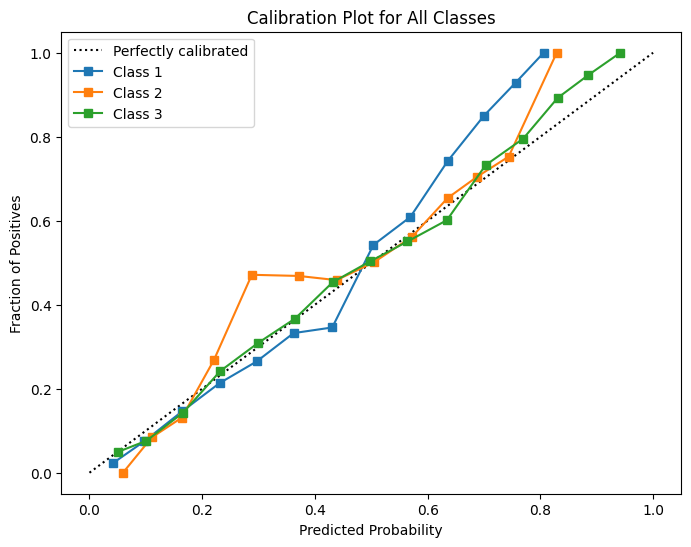

In [234]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay, calibration_curve

def Calibrator(X_test, y_test, estimator):
    y_pred = estimator.predict_proba(X_test)
    y_true = pd.get_dummies(y_test)

    # Создаем фигуру и оси для графиков
    fig, ax = plt.subplots(figsize=(8, 6))

    # Создаем калибровочные графики для каждого класса
    for klass in range(3):
        y_klass = np.array([])
        for i in range((y_pred.shape[0])):
            y_klass = np.append(y_klass, y_pred[i][klass])
        # Используем ax=ax для добавления графиков на общие оси
        CalibrationDisplay.from_predictions(y_true[klass+1], y_klass, n_bins=15, ax=ax, name=f'Class {klass+1}')

    # Добавляем легенду, заголовок и подписи осей
    ax.legend()
    ax.set_title('Calibration Plot for All Classes')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Fraction of Positives')

    # Отображаем график
    plt.show()

# Вызываем функцию с моделью
Calibrator(X_test, y_test, search)


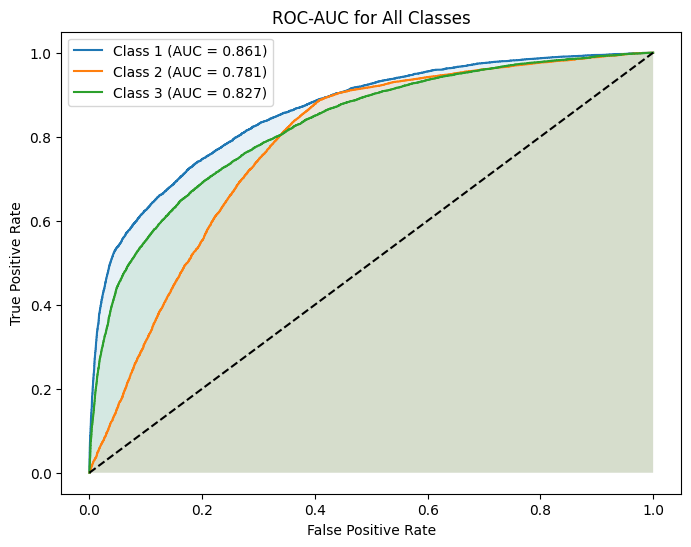

In [235]:
y_pred = search.predict_proba(X_test)
y_true = pd.get_dummies(y_test)

def RocAuc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    return fpr, tpr, auc(fpr, tpr)

# Создаем фигуру и оси для графиков
fig, ax = plt.subplots(figsize=(8, 6))

for klass in range(3):
    y_klass = np.array([])
    for i in range((y_pred.shape[0])):
        y_klass = np.append(y_klass, y_pred[i][klass])
    fpr, tpr, auc_value = RocAuc(y_true[klass+1], y_klass)
    ax.plot(fpr, tpr, label=f'Class {klass+1} (AUC = {round(auc_value, 3)})')
    ax.fill_between(fpr, tpr, alpha=0.1)

# Добавляем 45-градусную пунктирную линию
ax.plot([0, 1], [0, 1], linestyle='--', color='black')

# Добавляем легенду, заголовок и подписи осей
ax.legend()
ax.set_title('ROC-AUC for All Classes')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Отображаем график
plt.show()

### Задание 7

Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

Добавление полиномиальных признаков может быть полезным в некоторых случаях, потому что они позволяют модели улавливать нелинейные зависимости между признаками и целевой переменной. В реальных данных зависимости между переменными могут быть сложными и нелинейными, и модели с линейными предположениями (например, логистическая регрессия) могут не учитывать эти сложности.

Полиномиальные признаки могут улучшить производительность таких моделей, предоставляя дополнительные признаки, которые описывают нелинейные зависимости между исходными переменными. Однако добавление полиномиальных признаков также увеличивает размерность данных, что может привести к переобучению модели и ухудшению производительности на новых данных.

Важно заметить, что использование полиномиальных признаков не всегда приводит к улучшению производительности модели. Эффективность этого подхода зависит от характера данных и зависимостей, присутствующих в них. В некоторых случаях другие трансформации признаков или использование нелинейных моделей может быть более подходящим решением.

В целом, добавление полиномиальных признаков является одним из подходов к инженерии признаков, который может быть применен для улучшения производительности моделей машинного обучения. Однако, следует тщательно оценивать эффективность данного подхода на конкретных данных, чтобы избежать переобучения и потери производительности.

In [236]:
# Создаем копию исходного набора данных
X_polinomial = X.copy()

In [237]:
### Создание полиномиальных признаков

nonbin = X.nunique()>2
nonbin = nonbin[nonbin==True].index.to_list()

# Проходим по всем числовым столбцам
for col in nonbin:
    # Возводим числовые столбцы в степени 2, 3 и 4
    for power in [2, 3, 4]:
        
        # Вычисляем столбец с возведенными в степень значениями и переименовываем его
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        
        # Добавляем новый столбец к X_polinomial, объединяя по горизонтали
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

In [238]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [239]:
X_polinomial.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.427690,3.90500,0,40.000000,46,60,1,0,...,0,1600.000000,64000.000000,2.560000e+06,2116,97336,4477456,3600,216000,12960000
T0005689461,29.47,10.0,2.782450,3.45000,0,38.000000,56,78,1,0,...,0,1444.000000,54872.000000,2.085136e+06,3136,175616,9834496,6084,474552,37015056
T0005689464,41.58,10.0,2.802064,3.50125,2,64.202698,56,77,1,0,...,16,4121.986462,264642.652988,1.699077e+07,3136,175616,9834496,5929,456533,35153041
T0005689465,61.56,10.0,2.802064,3.45375,0,64.202698,52,74,0,1,...,0,4121.986462,264642.652988,1.699077e+07,2704,140608,7311616,5476,405224,29986576
T0005689467,54.95,10.0,3.034530,3.40250,4,51.000000,49,102,0,1,...,256,2601.000000,132651.000000,6.765201e+06,2401,117649,5764801,10404,1061208,108243216


In [240]:
X_pol_test

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_B,Type_of_Cab_C,...,Cancellation_Last_1Month_4,Var1_2,Var1_3,Var1_4,Var2_2,Var2_3,Var2_4,Var3_2,Var3_3,Var3_4
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005828439,29.32,2.000000,3.058280,3.50375,0,105.000000,52,80,0,0,...,0,11025.000000,1.157625e+06,1.215506e+08,2704,140608,7311616,6400,512000,40960000
T0005867265,20.93,8.000000,2.656770,3.50375,4,73.000000,50,87,0,1,...,256,5329.000000,3.890170e+05,2.839824e+07,2500,125000,6250000,7569,658503,57289761
T0005837398,30.15,7.000000,2.737880,2.51375,3,64.202698,50,66,0,1,...,81,4121.986462,2.646427e+05,1.699077e+07,2500,125000,6250000,4356,287496,18974736
T0005888871,16.12,10.000000,2.617260,2.87125,1,64.202698,54,75,1,0,...,1,4121.986462,2.646427e+05,1.699077e+07,2916,157464,8503056,5625,421875,31640625
T0005859728,67.13,7.000000,3.352070,3.48375,0,64.202698,53,84,0,0,...,0,4121.986462,2.646427e+05,1.699077e+07,2809,148877,7890481,7056,592704,49787136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T0005860557,41.57,7.000000,2.843690,3.04875,1,70.000000,50,77,0,0,...,1,4900.000000,3.430000e+05,2.401000e+07,2500,125000,6250000,5929,456533,35153041
T0005818708,34.10,10.000000,2.502960,2.47750,0,64.202698,46,59,0,1,...,0,4121.986462,2.646427e+05,1.699077e+07,2116,97336,4477456,3481,205379,12117361
T0005896460,91.62,6.016661,2.802064,3.22500,0,64.202698,48,67,0,0,...,0,4121.986462,2.646427e+05,1.699077e+07,2304,110592,5308416,4489,300763,20151121


Этот код создает новый набор данных `X_polinomial`, в котором числовые столбцы возведены в степени 2, 3 и 4. На каждой итерации цикла вычисляется новый столбец с возведенными в степень значениями, переименовывается с добавлением индекса степени к имени исходного столбца и добавляется к `X_polinomial`. В результате получается расширенный набор данных с дополнительными полиномиальными признаками, который затем может быть использован для обучения модели.

In [241]:
# Обучаем модель
pipe.fit(X_pol_train, y_train)
y_pred = pipe.predict(X_pol_test)

# Выводим отчет по классификации
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.585     0.653      9612

    accuracy                          0.683     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.683     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

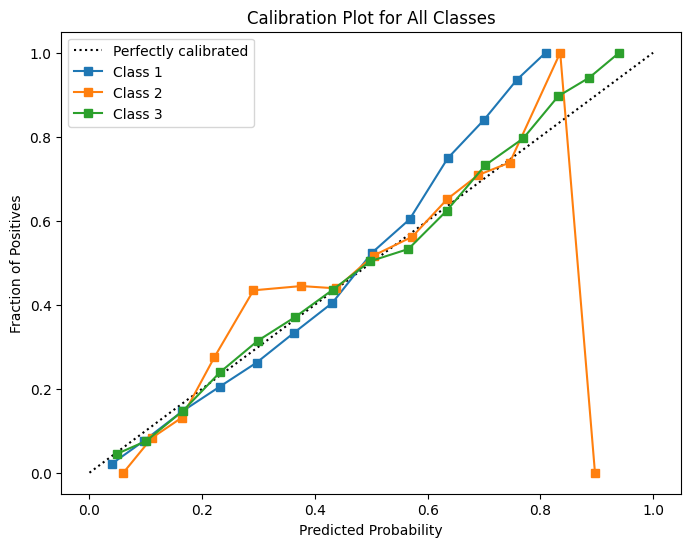

In [242]:
pipe_poly = pipe
pipe_poly.fit(X_pol_train, y_train)

Calibrator(X_pol_test, y_test, pipe_poly)

In [243]:
print(classification_report(y_test, pipe.predict(X_pol_test), labels=[1, 2, 3], digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.585     0.653      9612

    accuracy                          0.683     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.683     0.677     26333



Из полученного отчета классификации видно, что использование полиномиальных признаков до 4 степени вместе с логистической регрессией привело к небольшому улучшению производительности модели по сравнению с первым заданием. Метрики, такие как precision, recall, f1-score и accuracy, показывают незначительное увеличение.

Однако, стоит заметить, что улучшение метрик достаточно небольшое и может быть вызвано случайными факторами или некоторыми особенностями разбиения данных на обучающую и тестовую выборки. Всегда важно проверять устойчивость результатов на разных разбиениях данных, используя кросс-валидацию.

Таким образом, использование полиномиальных признаков в данном случае привело к небольшому улучшению производительности модели, но стоит продолжить исследования, используя другие методы инженерии признаков или попробовать более сложные модели, которые могут лучше улавливать нелинейные зависимости в данных.

### Задание 8 

Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [244]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [245]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [246]:
# Обучаем One-vs-One SGDClassifier:

sgd_clf = SGDClassifier(loss='hinge', random_state=42)  # Выберите 'hinge' для SVM или 'log' для LogReg
ovo_clf = OneVsOneClassifier(sgd_clf)
ovo_clf.fit(X_train_scaled, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [247]:
# Делаем прогнозы
y_pred = ovo_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           1      0.738     0.528     0.615      5372
           2      0.625     0.864     0.725     11349
           3      0.754     0.533     0.624      9612

    accuracy                          0.675     26333
   macro avg      0.706     0.642     0.655     26333
weighted avg      0.695     0.675     0.666     26333



Результаты показывают, что One-vs-One SGDClassifier достаточно хорошо справляется с задачей классификации для данного датасета. Однако, стоит отметить, что метрики различаются для разных классов.

Для класса 1:

- Precision составляет 0.738, что означает, что из всех объектов, которые модель определила как принадлежащих к классу 1, 73.8% действительно принадлежат этому классу.
- Recall составляет 0.528, что означает, что модель правильно определила 52.8% объектов, принадлежащих к классу 1.
- F1-score составляет 0.615, что является средним гармоническим между precision и recall и представляет общую производительность модели для данного класса.

Для класса 2:

- Precision составляет 0.625, recall - 0.864, а F1-score - 0.725.

Для класса 3:

- Precision составляет 0.754, recall - 0.533, а F1-score - 0.624.

Общая точность (accuracy) модели составляет 0.675, что означает, что 67.5% объектов были правильно классифицированы. Метрика macro avg учитывает метрики каждого класса и усредняет их, не учитывая размер класса, в то время как weighted avg учитывает размер класса в процессе усреднения. В данном случае, macro avg для precision, recall и F1-score составляют 0.706, 0.642 и 0.655 соответственно, а weighted avg - 0.695, 0.675 и 0.666.

В целом, модель показывает неплохую производительность, но её эффективность отличается для разных классов, особенно для класса 2. Возможно, стоит попробовать другие модели или подходы к обработке данных для улучшения результатов.

### Задание 9
Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [250]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Масштабирование данных
# Создаем экземпляр StandardScaler
scaler = StandardScaler()

# Обучаем StandardScaler и преобразуем тренировочные данные
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем тестовые данные с использованием обученного StandardScaler
X_test_scaled = scaler.transform(X_test)


# Создаем экземпляр модели One-vs-One SGDClassifier
model = OneVsOneClassifier(SGDClassifier())

# Задаем сетку параметров для GridSearchCV
param_grid = {'estimator__loss': ['hinge', 'log', 'modified_huber'],
              'estimator__penalty': ['l1', 'l2'],
              'estimator__alpha': [0.001, 0.01, 0.1]}

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(model, param_grid, n_jobs=-1)

# Обучаем модель на данных
grid_search.fit(X_train_scaled, y_train)

# Предсказываем на тестовом наборе данных
y_pred = grid_search.predict(X_test_scaled)

# Выводим отчет по классификации
print(classification_report(y_test, y_pred, digits=3))

# Выводим лучшие гиперпараметры
print("Best parameters: ", grid_search.best_params_)

              precision    recall  f1-score   support

           1      0.747     0.530     0.620      5372
           2      0.632     0.847     0.724     11349
           3      0.747     0.567     0.645      9612

    accuracy                          0.680     26333
   macro avg      0.709     0.648     0.663     26333
weighted avg      0.697     0.680     0.674     26333

Best parameters:  {'estimator__alpha': 0.1, 'estimator__loss': 'modified_huber', 'estimator__penalty': 'l2'}


Oтчет по классификации показывает результаты предсказания модели на тестовом наборе данных. Давайте разберем каждую метрику:

- **precision**: доля верно предсказанных положительных наблюдений от всех наблюдений, предсказанных как положительные. В вашем случае precision для класса 1 составляет 0.747, для класса 2 - 0.632, а для класса 3 - 0.747.
    
- **recall**: доля верно предсказанных положительных наблюдений от всех истинных положительных наблюдений. В вашем случае recall для класса 1 составляет 0.530, для класса 2 - 0.847, а для класса 3 - 0.567.
    
- **f1-score**: среднее гармоническое между precision и recall. Это позволяет учесть обе метрики в одной числовой оценке. В вашем случае f1-score для класса 1 составляет 0.620, для класса 2 - 0.724, а для класса 3 - 0.645.
    
- **support**: количество истинных наблюдений для каждого класса в тестовом наборе данных. В вашем случае support для класса 1 составляет 5372, для класса 2 - 11349, а для класса 3 - 9612.
    
- **accuracy**: общая доля верно предсказанных наблюдений. В вашем случае accuracy составляет 0.680.
    
- **macro avg**: среднее арифметическое всех метрик (precision, recall, f1-score) для всех классов, без учета размера класса. В вашем случае macro avg составляет 0.709 для precision, 0.648 для recall и 0.663 для f1-score.
    
- **weighted avg**: среднее арифметическое всех метрик (precision, recall, f1-score) для всех классов, с учетом размера класса. В вашем случае weighted avg составляет 0.697 для precision, 0.680 для recall и 0.674 для f1-score.
    

Лучшие параметры для модели, найденные с помощью GridSearchCV: `alpha` равен 0.1, `loss` равен 'modified\_huber', и `penalty` равен 'l2'.

Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?

Однако, в случае вашего набора данных, результаты One-vs-One и One-vs-Rest показали схожие показатели метрик (точность, полноту и F1-меру). На основе этого можно предположить, что в данном контексте оба подхода работают сопоставимо.